# Heart Failure Prediction

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, roc_auc_score

In [2]:
# sns.set_theme(rc = {'figure.figsize':(9, 7)})
set_config(display='diagram')

## Load Data

In [3]:
df = pd.read_csv('../data/heart.csv')

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
(df['Age'] >= 40).sum(), ((df['Age'] >= 40) & (df['HeartDisease'] > 0)).sum()

(838, 482)

In [5]:
tgt_col = 'HeartDisease'
feat_cols = df.columns.to_list()
feat_cols.remove(tgt_col)

feat_cols

['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope']

## EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


###### Note: No missing data

In [7]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


### Categorical Features

- Age
- Sex
- ChestPainType
- FastingBS
- RestingECG
- ExerciseAngina
- ST_Slope
- HeartDisease

### Numerical Features

- RestingBP
- Cholesterol
- MaxHR
- Oldpeak

In [8]:
cat_feats = ['Age_Bucket', 'Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']
num_feats = ['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
tgt_var = 'HeartDisease'

### Analyzing Categorical Features

#### Age Feature

##### Bucket Age

In [9]:
age_buckets = ['Child', 'Adolescence', 'Young Adult', 'Middle Aged', 'Aged', '80+']
df['Age_Bucket'] = pd.cut(df['Age'], bins=[0, 10, 19, 39, 59, 79, 100], 
                          labels=age_buckets, 
                          )

(
    ((df['Age_Bucket'] == 'Young Adult') & (df['HeartDisease'] == 0)).sum(), 
    ((df['Age_Bucket'] == 'Middle Aged') & (df['HeartDisease'] == 0)).sum(), 
    ((df['Age_Bucket'] == 'Aged') & (df['HeartDisease'] == 0)).sum(), 
    ((df['Age_Bucket'] == '80+') & (df['HeartDisease'] == 0)).sum()
)

(54, 288, 68, 0)

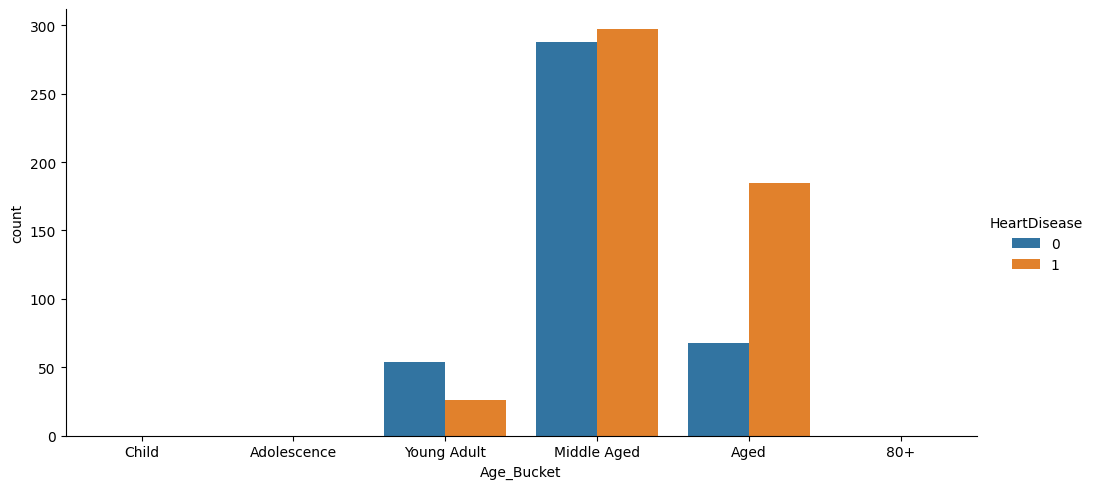

In [10]:
sns.catplot(df, kind='count', x='Age_Bucket', hue=tgt_col, aspect=2)

Text(0, 0.5, 'Age Category Percentage')

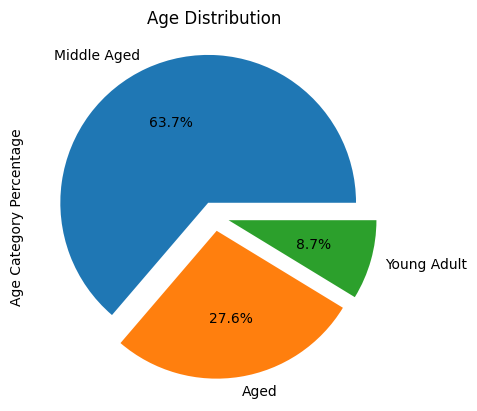

In [11]:
df['Age_Bucket'].value_counts().plot.pie(
    autopct=lambda p: '{:.1f}%'.format(p) if p > 0 else '', 
    explode=[0.1]*len(age_buckets))
plt.title('Age Distribution')
plt.ylabel('Age Category Percentage')

#### Gender feature

<Axes: xlabel='Sex', ylabel='count'>

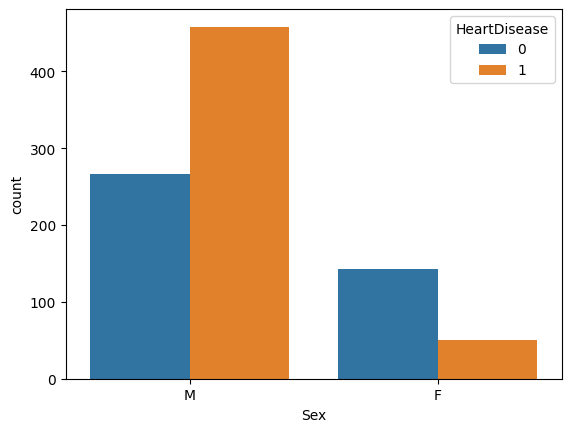

In [12]:
sns.countplot(df, x='Sex', hue=tgt_col)

Text(0, 0.5, 'Gender Category Percentage')

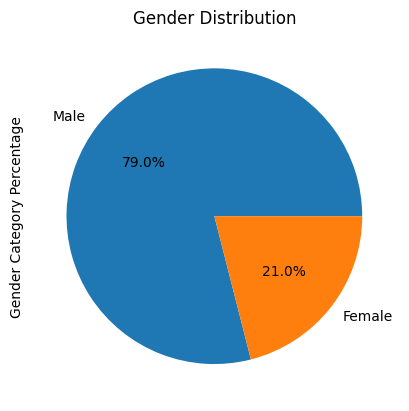

In [13]:
df['Sex'].map({'M': 'Male', 'F': 'Female'}).value_counts().plot.pie(autopct='%1.1f%%')

plt.title('Gender Distribution')
plt.ylabel('Gender Category Percentage')

#### Chest Pain Type Feature

<Axes: xlabel='ChestPainType', ylabel='count'>

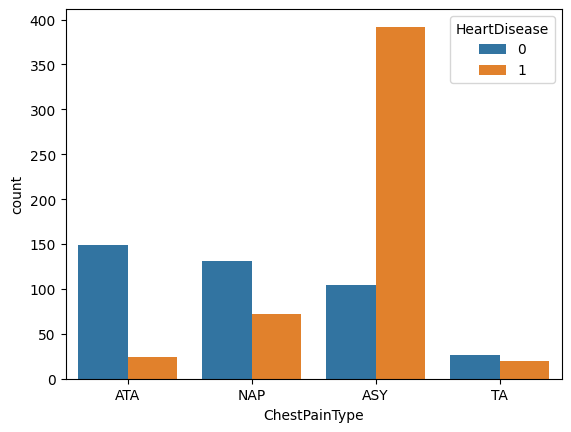

In [14]:
sns.countplot(df, x='ChestPainType', hue=tgt_col)

<Axes: xlabel='ChestPainType', ylabel='count'>

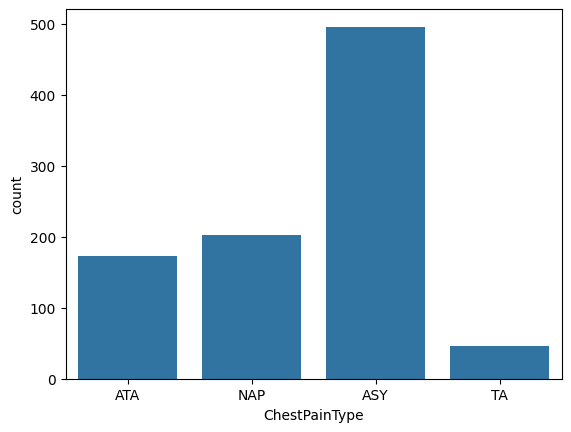

In [15]:
sns.countplot(df, x='ChestPainType')

#### Fasting Blood Sugar Feature

<Axes: xlabel='FastingBS', ylabel='count'>

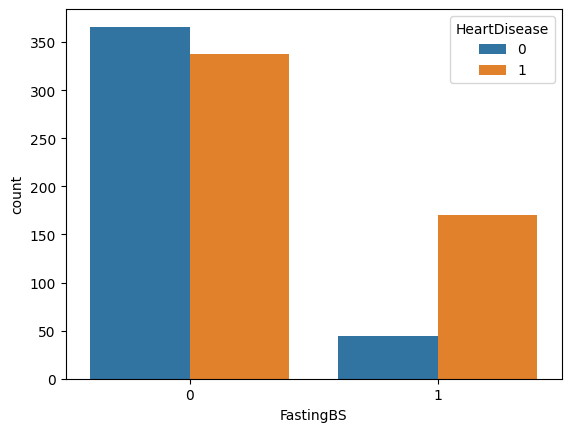

In [16]:
sns.countplot(df, x='FastingBS', hue=tgt_col)

Text(0, 0.5, '')

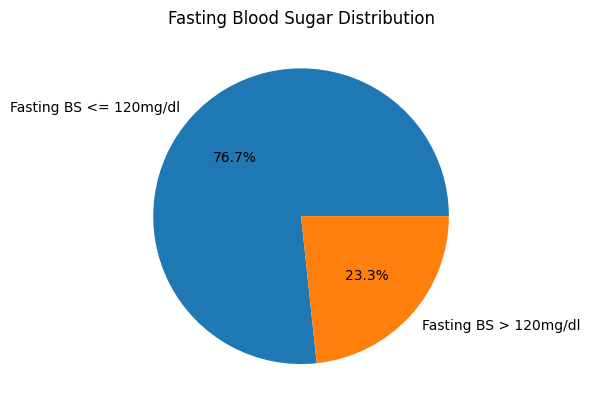

In [17]:
df['FastingBS'].map({
    0: 'Fasting BS <= 120mg/dl',
    1: 'Fasting BS > 120mg/dl'
}).value_counts().plot.pie(
    autopct='%1.1f%%'
)

plt.title('Fasting Blood Sugar Distribution')
plt.ylabel('')

#### Resting ECG

<Axes: xlabel='RestingECG', ylabel='count'>

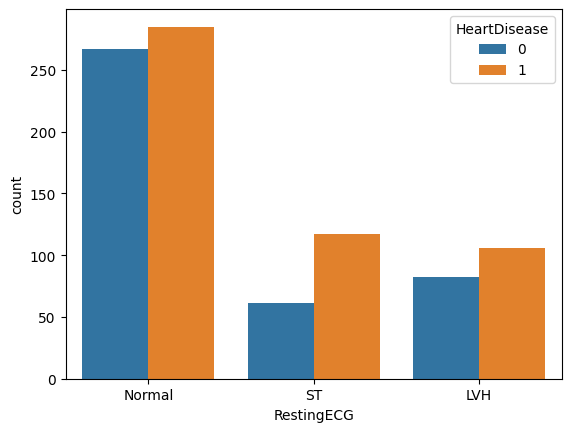

In [18]:
sns.countplot(df, x='RestingECG', hue=tgt_col)

Text(0, 0.5, '')

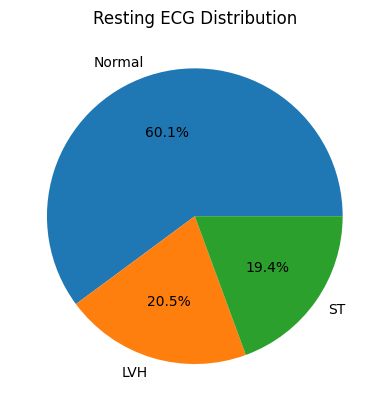

In [19]:
df['RestingECG'].value_counts().plot.pie(
    autopct='%1.1f%%'
)

plt.title('Resting ECG Distribution')
plt.ylabel('')

#### Exercise Induced Angina

<Axes: xlabel='ExerciseAngina', ylabel='count'>

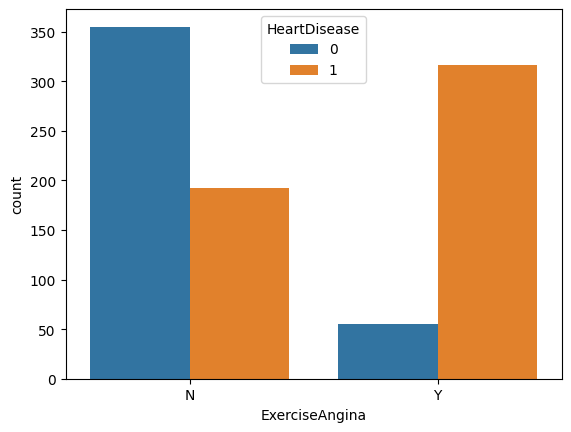

In [20]:
sns.countplot(df, x='ExerciseAngina', hue=tgt_col)

Text(0, 0.5, '')

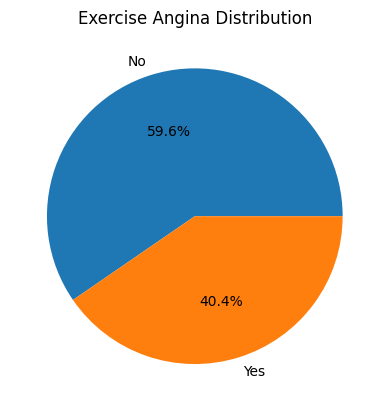

In [21]:
df['ExerciseAngina'].map({
    'Y': 'Yes',
    'N': 'No'
}).value_counts().plot.pie(
    autopct='%1.1f%%'
)

plt.title('Exercise Angina Distribution')
plt.ylabel('')

#### ST Slope Feature

<Axes: xlabel='ST_Slope', ylabel='count'>

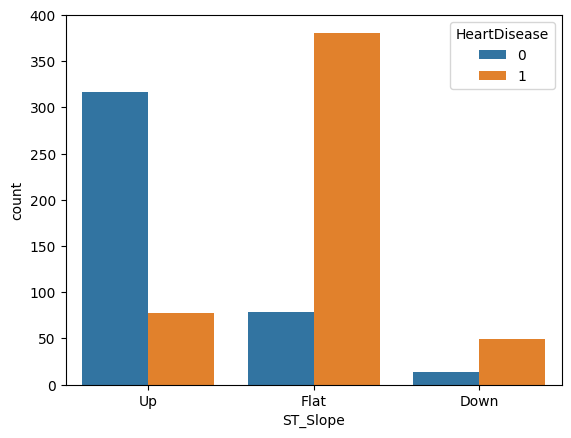

In [22]:
sns.countplot(df, x='ST_Slope', hue=tgt_col)

Text(0, 0.5, '')

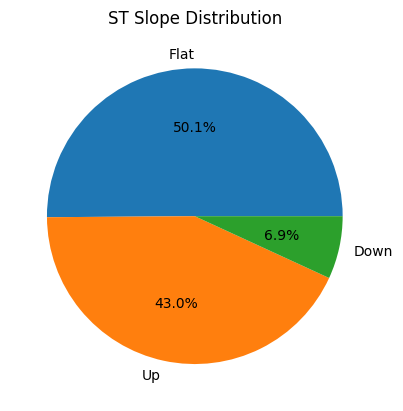

In [23]:
df['ST_Slope'].value_counts().plot.pie(
    autopct='%1.1f%%'
)

plt.title('ST Slope Distribution')
plt.ylabel('')

#### Heart Disease Distribution

Text(0, 0.5, '')

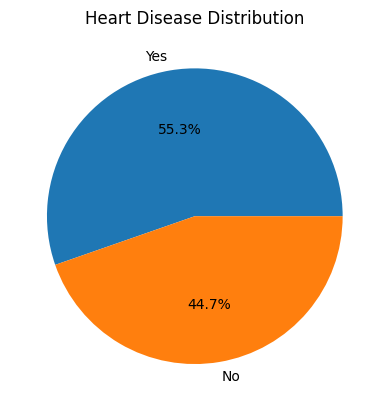

In [24]:
df['HeartDisease'].map({
    1: 'Yes',
    0: 'No'
}).value_counts().plot.pie(
    autopct='%1.1f%%'
)

plt.title('Heart Disease Distribution')
plt.ylabel('')

### Analyzing Numerical Features

#### Histogram & Scatter Plot

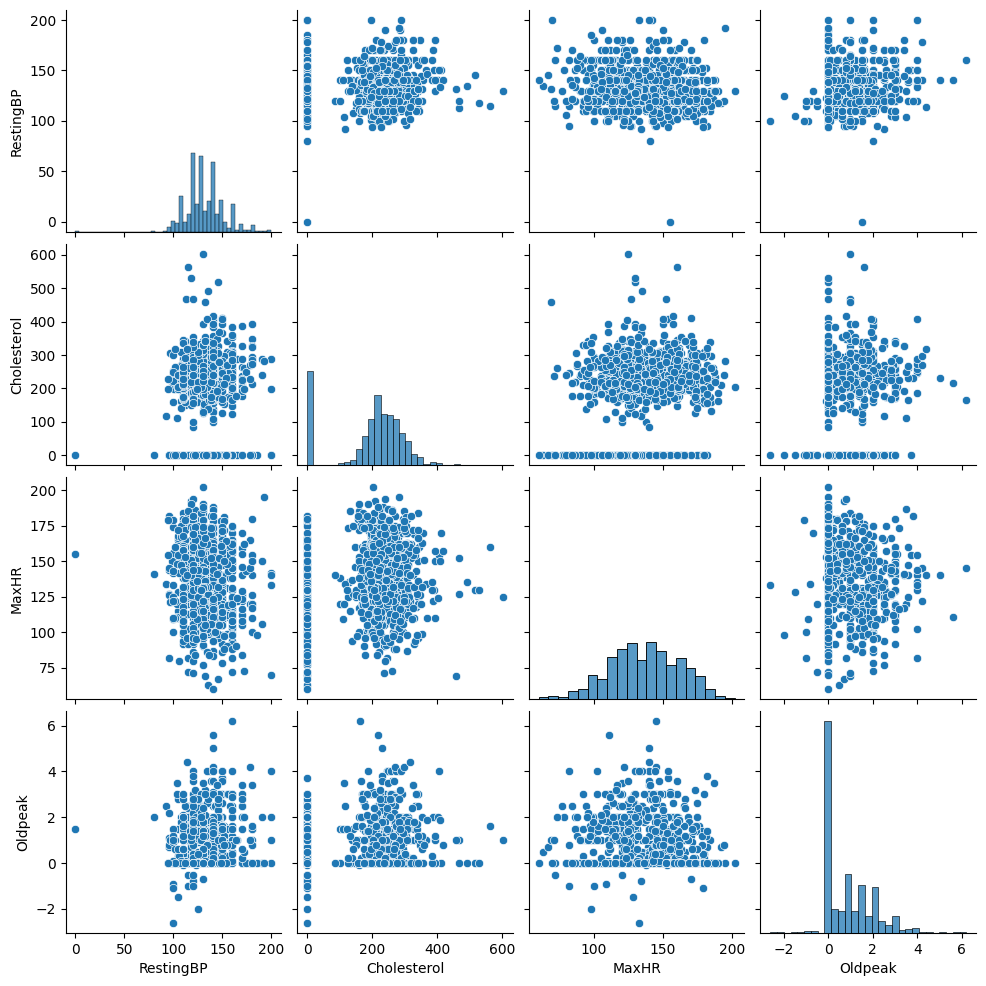

In [25]:
sns.pairplot(df, x_vars=num_feats, y_vars=num_feats)

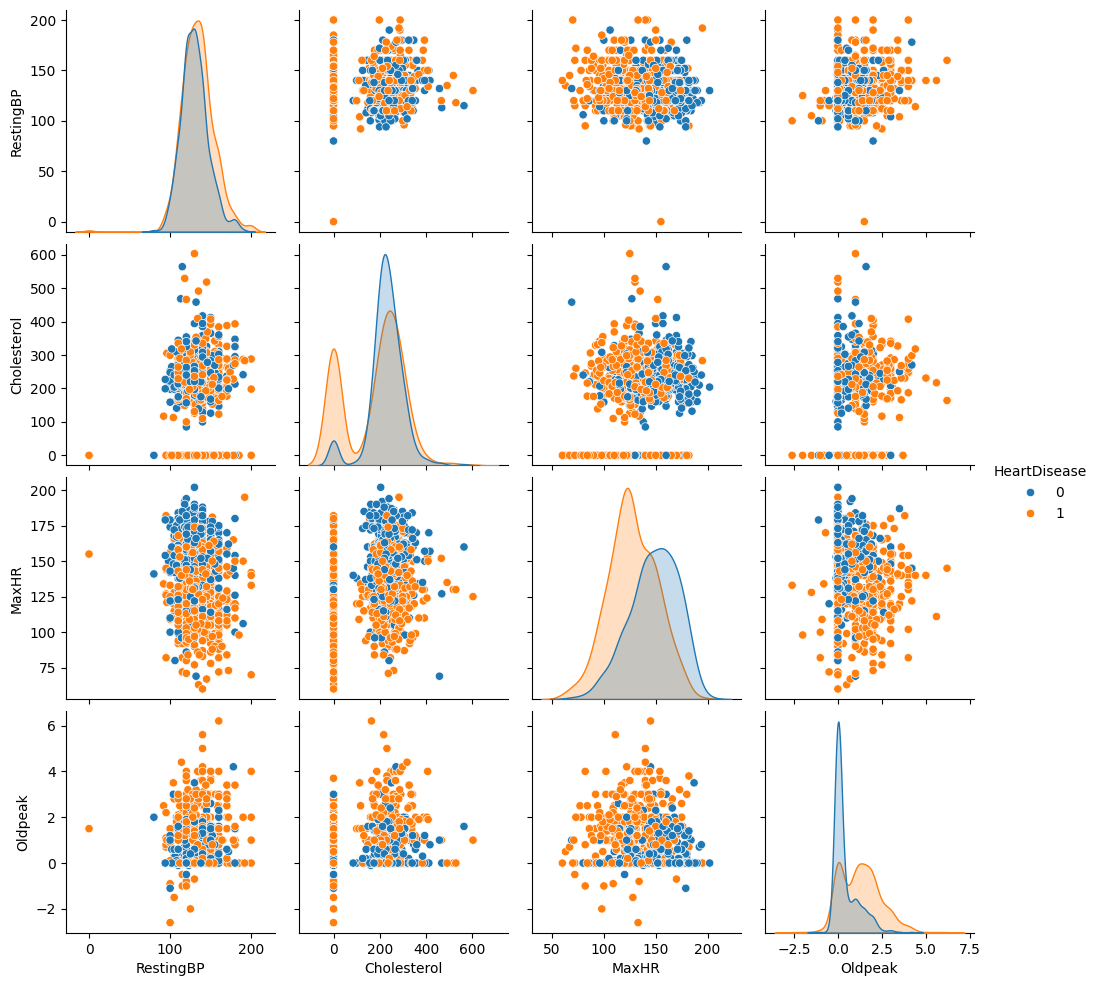

In [26]:
sns.pairplot(df, x_vars=num_feats, y_vars=num_feats, hue=tgt_col)

#### Detecting Outliers

##### Analyzing Resting BP

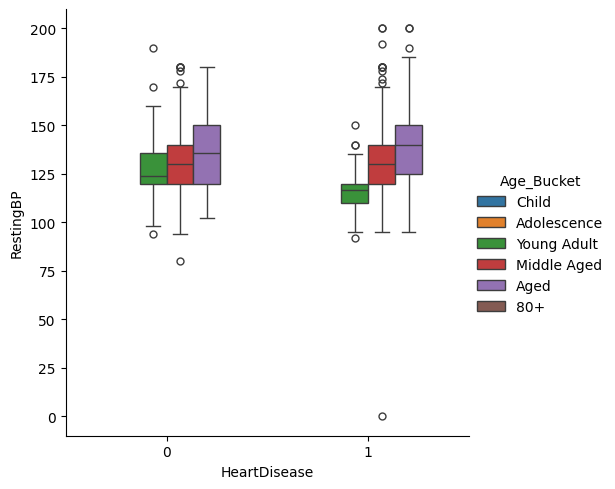

In [27]:
sns.catplot(df, kind='box', y='RestingBP', x='HeartDisease', hue='Age_Bucket')

In [28]:
df[df['RestingBP'] < 75]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Age_Bucket
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1,Middle Aged


###### Note: Resting BP is zero for record `449` which is not possible. Hence ignoring the record

##### Analyzing Cholesterol

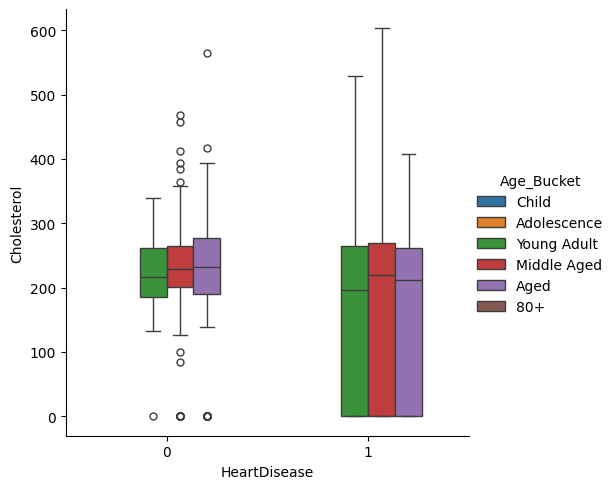

In [29]:
sns.catplot(df, kind='box', y='Cholesterol', x='HeartDisease', hue='Age_Bucket')

In [30]:
df[df['Cholesterol'] < 100]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Age_Bucket
98,56,M,ASY,120,85,0,Normal,140,N,0.0,Up,0,Middle Aged
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1,Aged
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1,Young Adult
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1,Aged
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1,Middle Aged
...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1,Middle Aged
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0,Aged
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1,Middle Aged
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1,Middle Aged


###### Note: Cholesterol value cannot be equal to 0. Which means error in data collection 

##### Converting Cholesterol into Categorical Variable

In [31]:
df['Cholesterol'].describe()

count    918.000000
mean     198.799564
std      109.384145
min        0.000000
25%      173.250000
50%      223.000000
75%      267.000000
max      603.000000
Name: Cholesterol, dtype: float64

In [32]:
# Based on domain knowledge Cholestrol can created into Healthy, At-Risk, Dangerous
df['Cholesterol_Cat'] = pd.cut(df['Cholesterol'], bins=[-1, 199, 239, 1000], labels=['Normal', 'At-Risk', 'Dangerous'])

df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Age_Bucket,Cholesterol_Cat
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,Middle Aged,Dangerous
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,Middle Aged,Normal
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,Young Adult,Dangerous
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,Middle Aged,At-Risk
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,Middle Aged,Normal


Text(0.5, 1.0, 'Count Plot of Cholesterol by category')

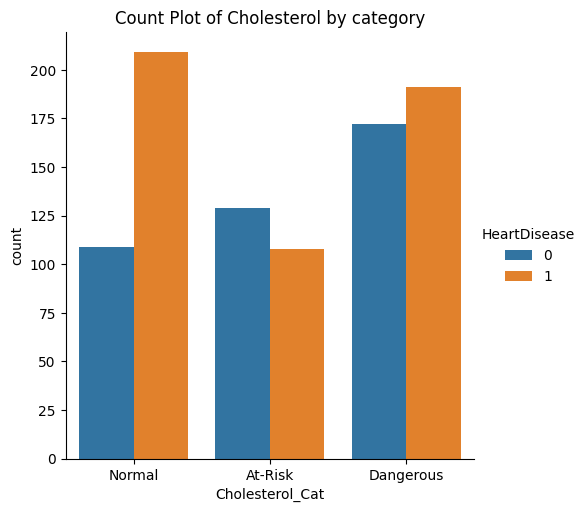

In [33]:
sns.catplot(df, kind='count', x='Cholesterol_Cat', hue='HeartDisease')
plt.title('Count Plot of Cholesterol by category')

In [34]:
df[df['Cholesterol_Cat'].isna()]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Age_Bucket,Cholesterol_Cat


#### Analyzing Heart Rate

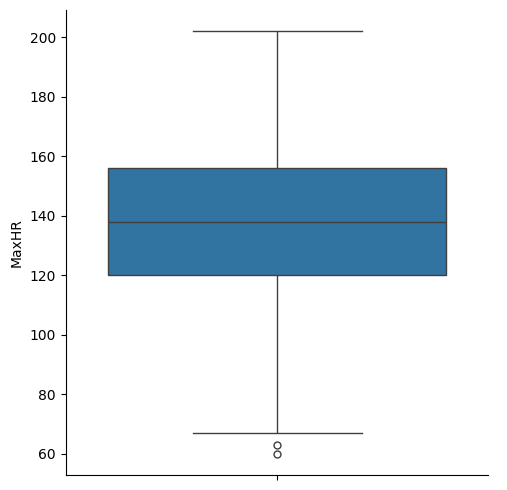

In [35]:
sns.catplot(df, kind='box', y='MaxHR')

In [36]:
df['MaxHR'].describe()

count    918.000000
mean     136.809368
std       25.460334
min       60.000000
25%      120.000000
50%      138.000000
75%      156.000000
max      202.000000
Name: MaxHR, dtype: float64

In [37]:
df[df['MaxHR'] < 80]['MaxHR'].value_counts()

MaxHR
72    2
77    1
63    1
60    1
70    1
67    1
78    1
69    1
73    1
71    1
Name: count, dtype: int64

##### Analyzing Old Peak

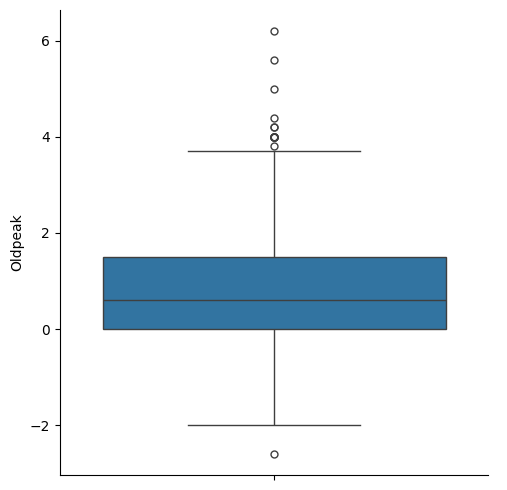

In [38]:
sns.catplot(df, kind='box', y='Oldpeak')

### Handling Outlier

#### Resting BP

In [39]:
df = df[df['RestingBP'] != 0]

In [40]:
df[df['RestingBP'] < 75]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,Age_Bucket,Cholesterol_Cat


## Split Data to Train & Test

In [41]:
num_feats = ['RestingBP', 'MaxHR', 'Oldpeak']
ord_feats = ['Cholesterol_Cat', 'FastingBS', 'ExerciseAngina', 'Age_Bucket']
nom_feats = ['Sex', 'ChestPainType', 'RestingECG', 'ST_Slope']
tgt_feat = 'HeartDisease'

In [42]:
X = df[num_feats+ord_feats+nom_feats]
y = df[tgt_feat]

In [43]:
X.shape, y.shape

((917, 11), (917,))

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.2)

## Feature Transformation

### Numerical Features

In [45]:
X_train[num_feats].head()

,RestingBP,MaxHR,Oldpeak
161,128,96,0.0
604,134,151,0.0
659,126,134,2.2
793,125,163,0.2
140,160,94,2.5


In [46]:
list(map(lambda x: X_train.columns.to_list().index(x), num_feats))

[0, 1, 2]

In [47]:
def gen_feat_pipe(df, num_feats, ord_feats, nom_feats):

    cols = df.columns.to_list()

    num_stage = ColumnTransformer([
        (
            'num_feat_scale', 
            StandardScaler(),
            list(map(lambda x: cols.index(x), num_feats))
        )
    ], remainder='passthrough')

    cat_stage = ColumnTransformer([
        (
            'cat_enc_ord',
            OrdinalEncoder(),
            list(map(lambda x: cols.index(x), ord_feats))
        ),
        (
            'cat_enc_nom',
            OneHotEncoder(),
            list(map(lambda x: cols.index(x), nom_feats))
        ),
    ], remainder='passthrough')

    return [
        ('num_trans', num_stage),
        ('cat_trans', cat_stage)
    ]

## Build Model

In [48]:
def train_model(model, params, train_feats, train_label):

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

    clf = GridSearchCV(model, params, cv=cv, scoring='accuracy', n_jobs=-1)
    clf.fit(train_feats, train_label)

    print('Best Params', clf.best_params_)
    print('Best Params', clf.best_score_)

    return clf

In [49]:
def test_model(model, test_feats, test_label):

    pred_label = model.predict(test_feats)
    pred_label_proba = model.predict_proba(test_feats)
    
    print('*'*10, 'classification_report', '*'*10)
    print(classification_report(test_label, pred_label))
    print('*'*10, 'confusion_matrix', '*'*10)
    # print(confusion_matrix(test_label, pred_label))
    disp = ConfusionMatrixDisplay(confusion_matrix(test_label, pred_label))
    disp.plot()
    print('*'*10, 'roc_auc_score', '*'*10)
    print(roc_auc_score(test_label, pred_label))

    result = {}
    prec, rec, thres_prec_rec = precision_recall_curve(test_label, pred_label_proba[:, 1])
    fpr, tpr, thres_roc = roc_curve(test_label, pred_label_proba[:, 1])

    result['prec_rec_curve'] = prec, rec, thres_prec_rec
    result['roc_curve'] =  fpr, tpr, thres_roc

    fig, ax = plt.subplots(figsize=(20, 12))
    ax.plot(fpr, tpr)
    for f, t, th in zip(fpr, tpr, thres_roc):
        ax.text(f, t, '{:.1f}'.format(th), ha='right', va='bottom')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

    return result

### Build Logistic Regression Pipeline

In [50]:
hyper_parmas = {
    'log_reg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'log_reg__penalty': ['l2'],
    'log_reg__solver': ['newton-cg', 'lbfgs', 'liblinear']
}

pipeline_list = gen_feat_pipe(
    X_train,
    num_feats,
    ord_feats,
    nom_feats
)
pipeline_list.append(
    ('log_reg', LogisticRegression())
)

print(pipeline_list)

pipeline = Pipeline(pipeline_list)

clf = train_model(pipeline, hyper_parmas, X_train, y_train)

[('num_trans', ColumnTransformer(remainder='passthrough',
                  transformers=[('num_feat_scale', StandardScaler(),
                                 [0, 1, 2])])), ('cat_trans', ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_enc_ord', OrdinalEncoder(), [3, 4, 5, 6]),
                                ('cat_enc_nom', OneHotEncoder(),
                                 [7, 8, 9, 10])])), ('log_reg', LogisticRegression())]


Best Params {'log_reg__C': 0.1, 'log_reg__penalty': 'l2', 'log_reg__solver': 'liblinear'}
Best Params 0.8576460721274812


********** classification_report **********
              precision    recall  f1-score   support

           0       0.86      0.85      0.86        82
           1       0.88      0.89      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184

********** confusion_matrix **********
********** roc_auc_score **********
0.872907699665232


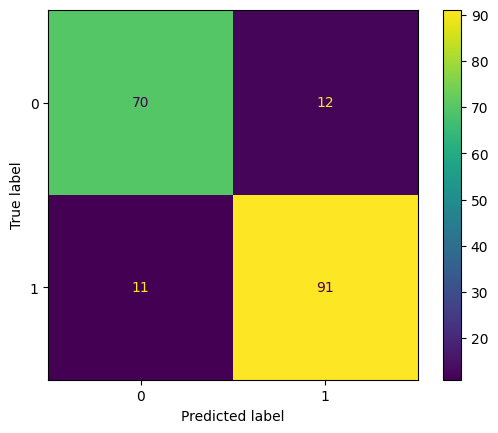

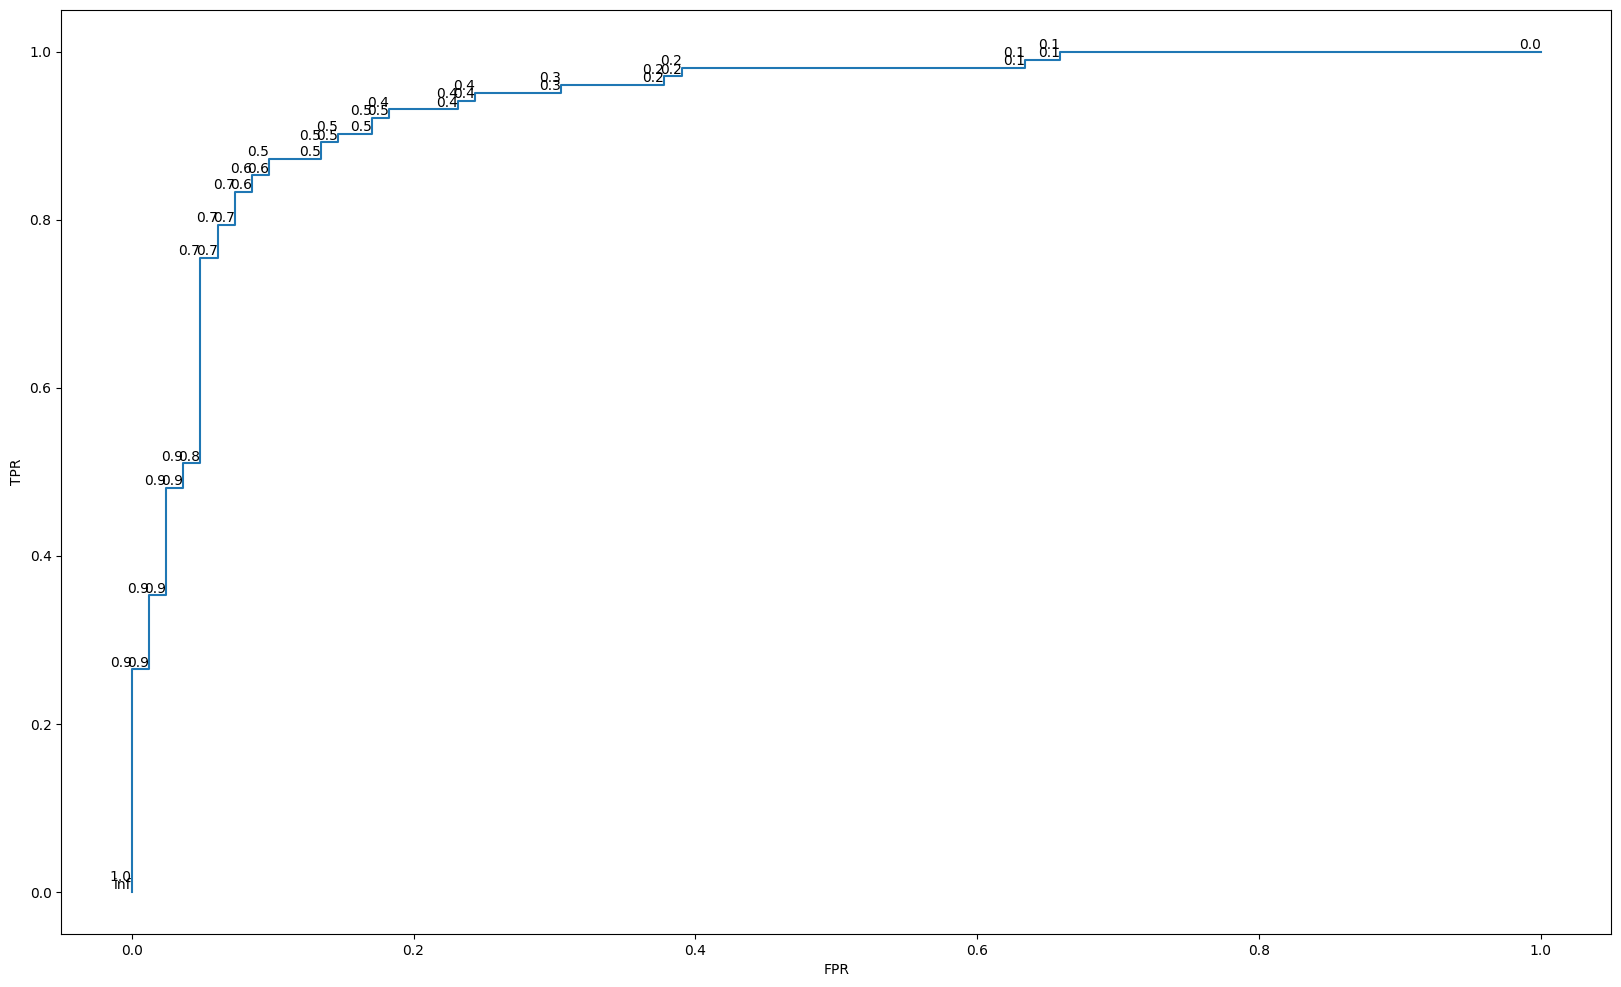

In [51]:
result = test_model(clf, X_test, y_test)

### Build Random Forest Classification Pipeline

In [52]:
hyper_parmas = {
    'random_forest__max_depth': [3, 6, 9],
    # 'random_forest__min_samples_split': [2, 5, 10],
    # 'random_forest__max_leaf_nodes': [3, 6, 9],
    # 'random_forest__min_samples_leaf': [1, 2, 4],
    'random_forest__n_estimators': range(50, 301, 50),
    'random_forest__max_features': ['sqrt', 'log2']
}

pipeline_list = gen_feat_pipe(
    X_train,
    num_feats,
    ord_feats,
    nom_feats
)
pipeline_list.append(
    ('random_forest', RandomForestClassifier())
)

print(pipeline_list)

pipeline = Pipeline(pipeline_list)

clf = train_model(pipeline, hyper_parmas, X_train, y_train)

[('num_trans', ColumnTransformer(remainder='passthrough',
                  transformers=[('num_feat_scale', StandardScaler(),
                                 [0, 1, 2])])), ('cat_trans', ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_enc_ord', OrdinalEncoder(), [3, 4, 5, 6]),
                                ('cat_enc_nom', OneHotEncoder(),
                                 [7, 8, 9, 10])])), ('random_forest', RandomForestClassifier())]
Best Params {'random_forest__max_depth': 6, 'random_forest__max_features': 'sqrt', 'random_forest__n_estimators': 300}
Best Params 0.8621750069890969


********** classification_report **********
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        82
           1       0.89      0.91      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184

********** confusion_matrix **********
********** roc_auc_score **********
0.8827116212338593


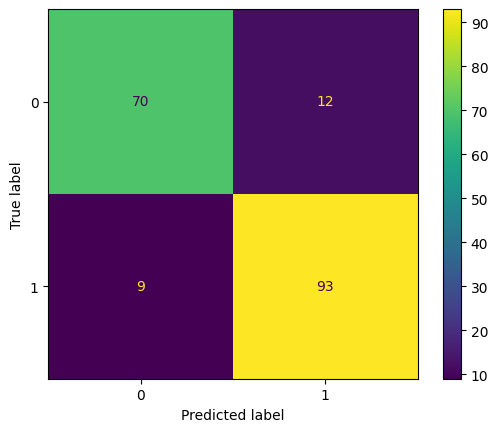

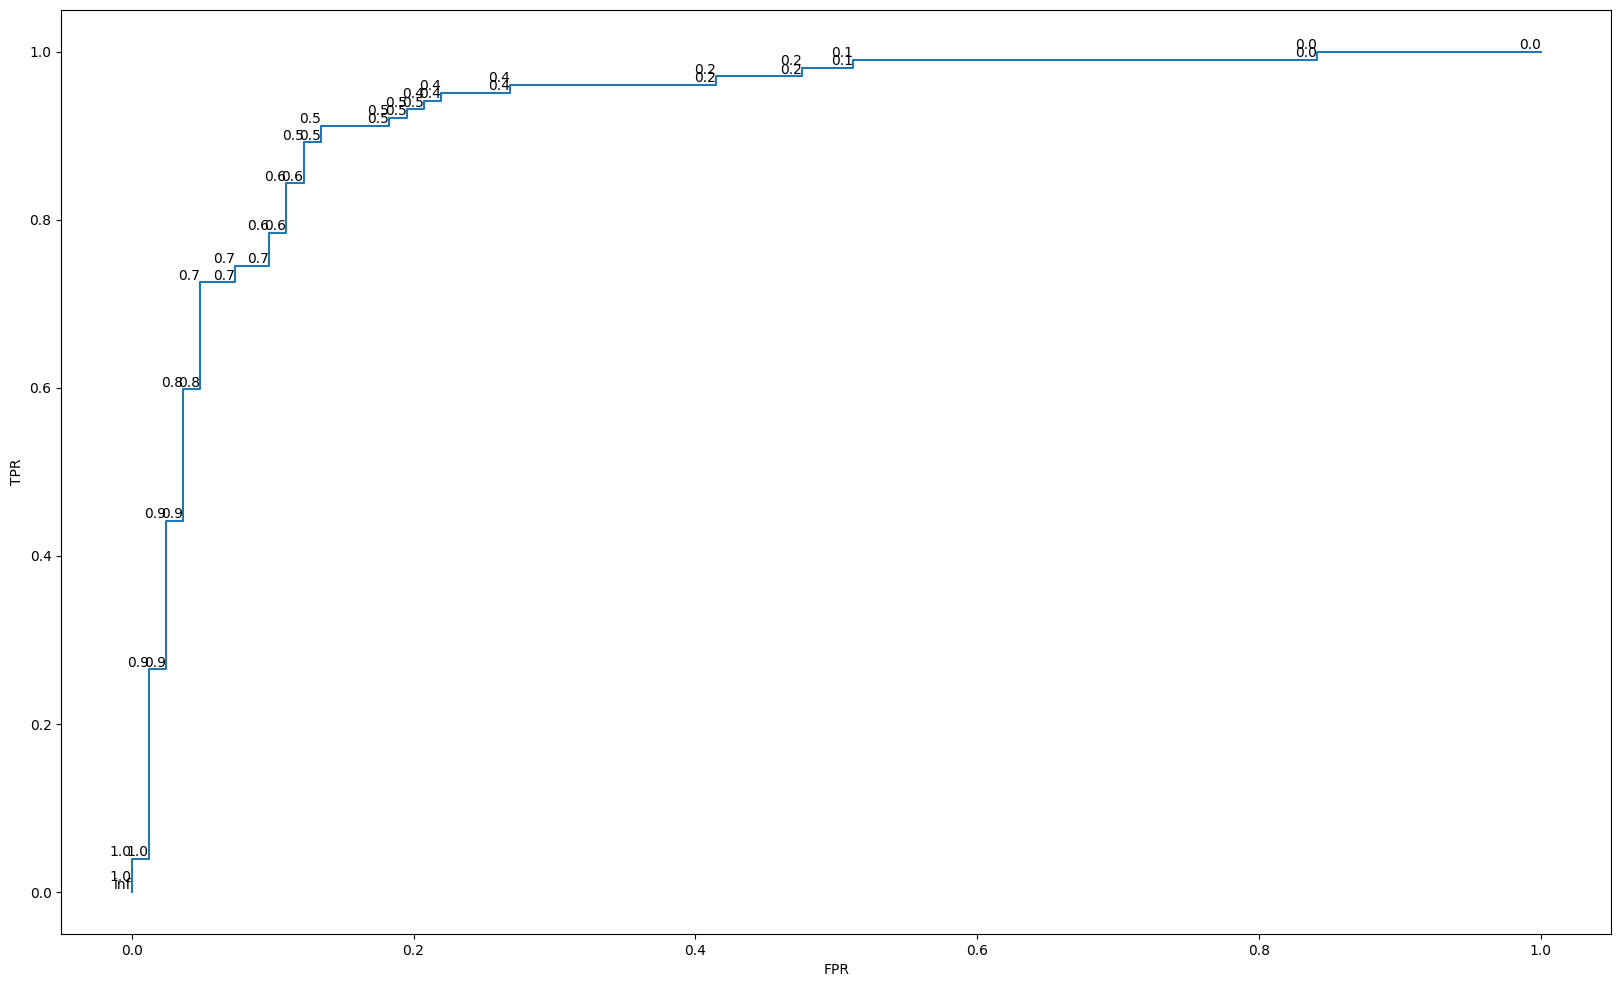

In [54]:
result = test_model(clf, X_test, y_test)

#### Random Forest without Scaling & encoding features

In [55]:
pipeline_list = gen_feat_pipe(
    X_train,
    num_feats,
    ord_feats,
    nom_feats
)
pipeline_list.append(
    ('random_forest', RandomForestClassifier())
)
pipeline_list.pop(0)

print(pipeline_list)

pipeline = Pipeline(pipeline_list)

clf = train_model(pipeline, hyper_parmas, X_train, y_train)

[('cat_trans', ColumnTransformer(remainder='passthrough',
                  transformers=[('cat_enc_ord', OrdinalEncoder(), [3, 4, 5, 6]),
                                ('cat_enc_nom', OneHotEncoder(),
                                 [7, 8, 9, 10])])), ('random_forest', RandomForestClassifier())]
Best Params {'random_forest__max_depth': 6, 'random_forest__max_features': 'log2', 'random_forest__n_estimators': 50}
Best Params 0.8649085204858198


********** classification_report **********
              precision    recall  f1-score   support

           0       0.87      0.84      0.86        82
           1       0.88      0.90      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184

********** confusion_matrix **********
********** roc_auc_score **********
0.8717120994739359


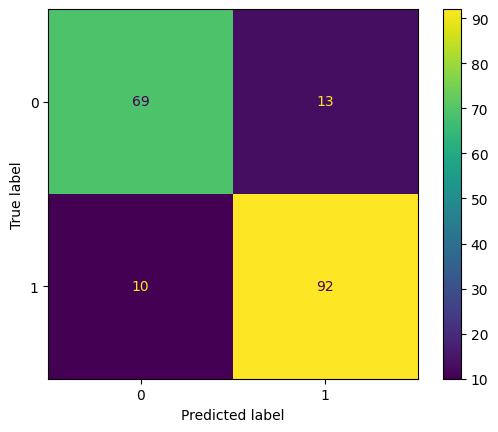

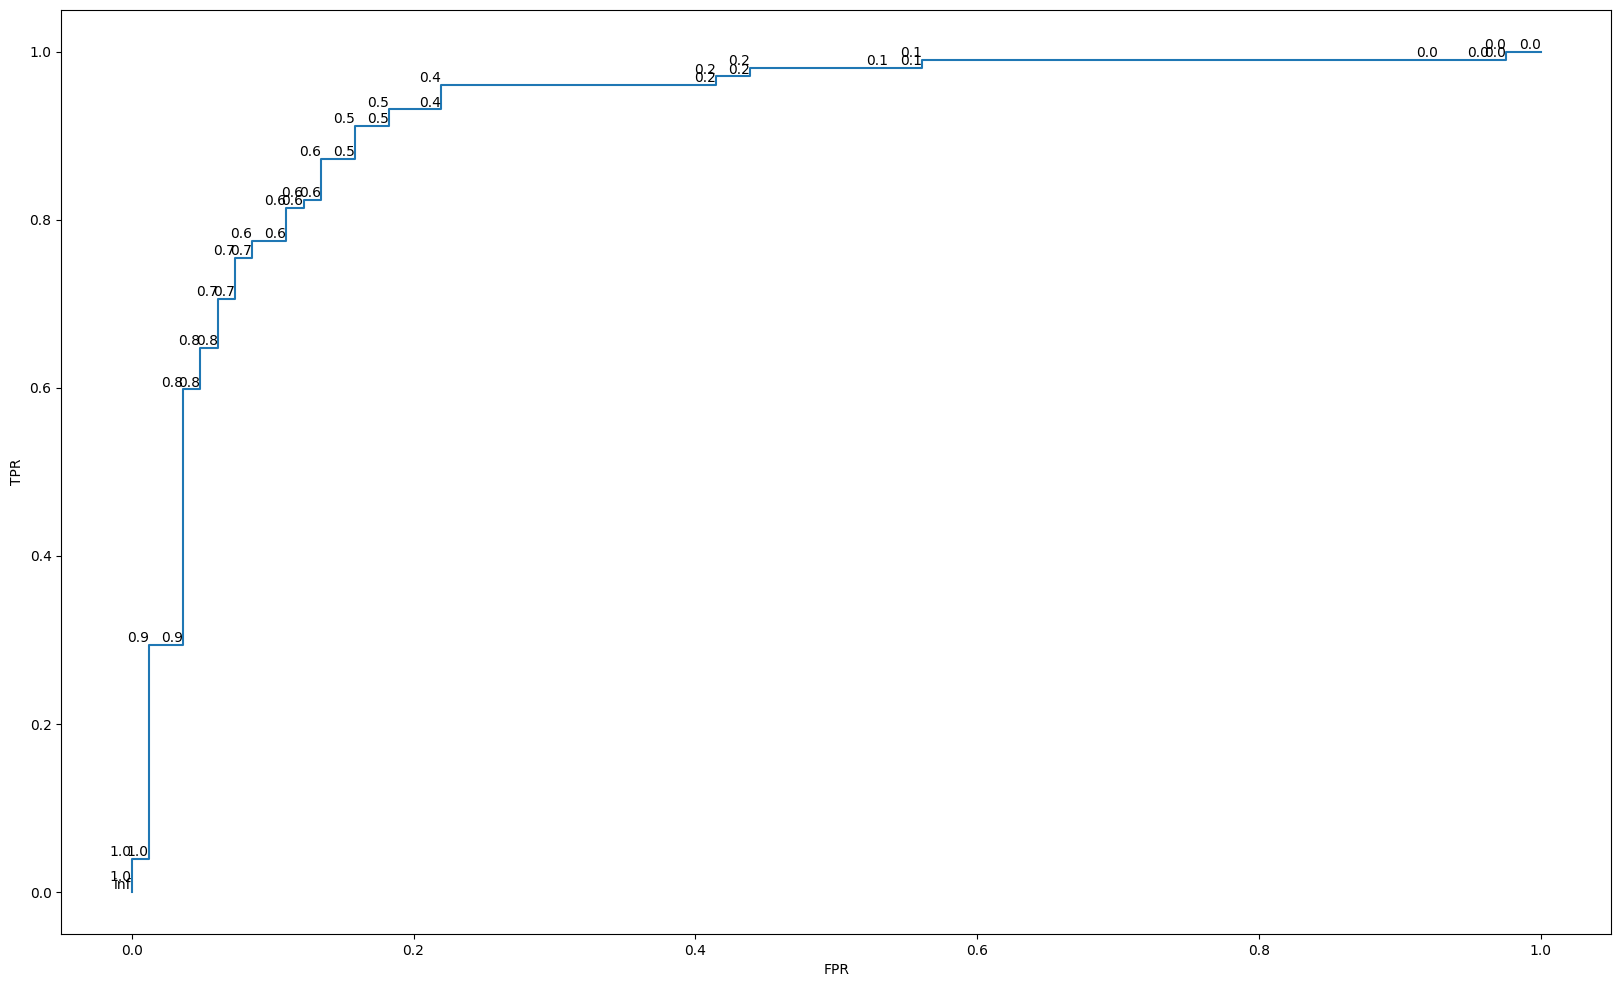

{'prec_rec_curve': (array([0.55434783, 0.55737705, 0.56043956, 0.55801105, 0.56111111,
         0.57062147, 0.57386364, 0.57714286, 0.58045977, 0.58381503,
         0.5872093 , 0.59064327, 0.59411765, 0.59763314, 0.60119048,
         0.60479042, 0.60843373, 0.61212121, 0.61585366, 0.6196319 ,
         0.62345679, 0.62732919, 0.63125   , 0.63522013, 0.63924051,
         0.6433121 , 0.6474359 , 0.6516129 , 0.65584416, 0.66013072,
         0.66447368, 0.66887417, 0.67333333, 0.67785235, 0.68243243,
         0.68707483, 0.68493151, 0.69444444, 0.6993007 , 0.70422535,
         0.70921986, 0.71428571, 0.71942446, 0.72463768, 0.72992701,
         0.73529412, 0.73333333, 0.73880597, 0.7443609 , 0.74242424,
         0.7480916 , 0.75384615, 0.75968992, 0.765625  , 0.77165354,
         0.77777778, 0.784     , 0.79032258, 0.79674797, 0.80327869,
         0.80991736, 0.81666667, 0.82352941, 0.83050847, 0.83760684,
         0.84482759, 0.84347826, 0.84210526, 0.84070796, 0.84821429,
         0.85585

In [56]:
test_model(clf, X_test, y_test)

### Inference

- Model training accuracy seems to be approx. same value of test accuracy. Hence there's no overfitting